In [1]:
import sys
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


sys.path.append("../..")
from burgers.plot import plot_1d_image
from model import Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
######### DATA #########
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(-3.0 * x)

def exact_sol(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return torch.exp(-3.0 * x - 2.0 * t)

ic_sparsity = 1.0
pde_sparsity = 0.1
rng = np.random.default_rng(0)

# Grid
position = np.arange(0.0, 2.0, 0.02, dtype=np.float32)
time = np.arange(0.0, 1.0, 0.01, dtype=np.float32)
xt = np.stack(np.meshgrid(position, time), axis=-1)   # [S, T, 2]

# Initial condition
ic_x = torch.tensor(xt[0, :, 0]).reshape(-1, 1)
ic_t = torch.zeros_like(ic_x)
ic_u = initial_condition(ic_x)
num_ic = int(len(ic_x) * ic_sparsity)

idx = rng.choice(len(ic_x), num_ic, replace=False)
ic_x = ic_x[idx].to(device)
ic_t = ic_t[idx].to(device)
ic_u = ic_u[idx].to(device)

# PDE condition
pde_x = torch.tensor(xt[..., 0], device=device).reshape(-1, 1)
pde_t = torch.tensor(xt[..., 1], device=device).reshape(-1, 1)
num_pde = int(len(pde_x) * pde_sparsity)

idx = rng.choice(len(pde_x), num_pde, replace=False)
pde_x = pde_x[idx].to(device)
pde_t = pde_t[idx].to(device)

print(f"{num_ic=}, {num_pde=}")

num_ic=100, num_pde=1000


In [3]:
model = Model(in_dim=2, hidden_dim=16, out_dim=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [4]:
# PDE loss
def get_pde_loss(x: torch.Tensor,t: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    pde = u_x - 2*u_t - u

    return pde.square().mean()

In [5]:
### (3) Training / Fitting
epochs = 10000
best_loss = 99999999.0

loss_ic: list[float] = []
loss_pde: list[float] = []
loss_total: list[float] = []
loss_test: list[float] = []

best_model_state_dict = copy.deepcopy(model.state_dict())
model.train()
for epoch in range(epochs):
    # Initial condition
    pred_ic_field = model(ic_x, ic_t)
    mse_ic = F.mse_loss(pred_ic_field, ic_u)

    # PDE condition
    pde_x1 = pde_x.requires_grad_(True)
    pde_t1 = pde_t.requires_grad_(True)
    pred_pde_field = model(pde_x1, pde_t1)
    mse_pde = get_pde_loss(pde_x1, pde_t1, pred_pde_field)

    # Combining the loss functions
    loss = mse_ic + mse_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if best_loss > loss.item():
        best_loss = loss.item()
        best_model_state_dict = copy.copy(model.state_dict())
        print(epoch, "Traning Loss:", best_loss)
    loss_ic.append(mse_ic.item())
    loss_pde.append(mse_pde.item())
    loss_total.append(loss.item())

last_model_state_dict = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_state_dict)

0 Traning Loss: 0.11524069309234619
1 Traning Loss: 0.10845893621444702
2 Traning Loss: 0.10230527818202972
3 Traning Loss: 0.09678670763969421
4 Traning Loss: 0.09190578758716583
5 Traning Loss: 0.0876598209142685
6 Traning Loss: 0.08403973281383514
7 Traning Loss: 0.0810292512178421
8 Traning Loss: 0.07860386371612549
9 Traning Loss: 0.07673020660877228
10 Traning Loss: 0.07536552101373672
11 Traning Loss: 0.0744577944278717
12 Traning Loss: 0.07394641637802124
13 Traning Loss: 0.07376373559236526
35 Traning Loss: 0.07375499606132507
36 Traning Loss: 0.07375417649745941
54 Traning Loss: 0.07374846190214157
55 Traning Loss: 0.07374172657728195
56 Traning Loss: 0.07374066114425659
70 Traning Loss: 0.0737401470541954
71 Traning Loss: 0.07373552024364471
72 Traning Loss: 0.07373211532831192
73 Traning Loss: 0.07372990995645523
74 Traning Loss: 0.07372879236936569
75 Traning Loss: 0.0737285166978836
83 Traning Loss: 0.07372745871543884
84 Traning Loss: 0.07372580468654633
85 Traning Loss:

<All keys matched successfully>

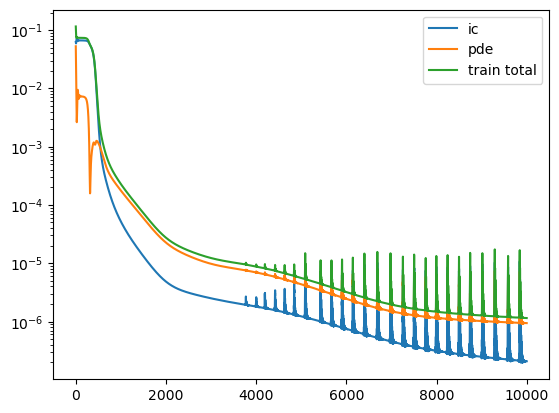

In [6]:
plt.plot(loss_ic, label="ic")
plt.plot(loss_pde, label="pde")
plt.plot(loss_total, label="train total")
# plt.plot(loss_test, label="test")

plt.legend()
plt.yscale("log")
plt.show()

In [18]:
xt = np.stack(np.meshgrid(position, time), axis=-1)  # [S, N, 2]
x = torch.tensor(xt[..., 0], device=device).reshape(-1, 1)
t = torch.tensor(xt[..., 1], device=device).reshape(-1, 1)

with torch.no_grad():
    model.eval()
    pred_field = model(x, t).cpu().numpy()
    true_field = exact_sol(x, t).cpu().numpy()

true_trajectory = true_field.reshape(len(time), len(position), 1)
pred_trajectory = pred_field.reshape(len(time), len(position), 1)
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=3.7808e-04, in range (-0.00077532325, 0.0020616055)


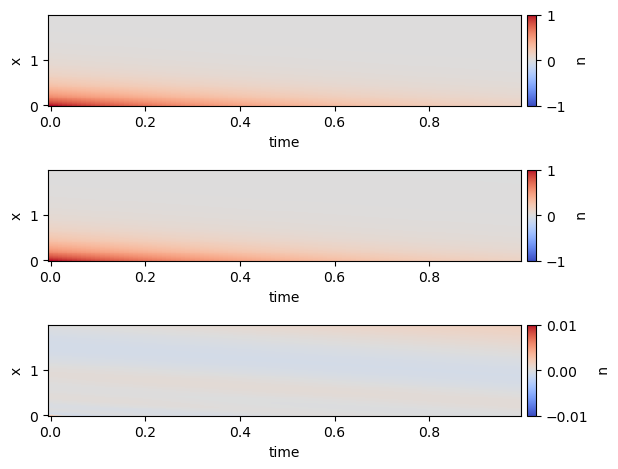

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

im1 = plot_1d_image(
    ax1, time, position, true_trajectory, to_periodic=False, rasterized=True
)
cbar = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax1.set_xlabel("time")
ax1.set_ylabel("x")

im2 = plot_1d_image(
    ax2, time, position, pred_trajectory, to_periodic=False, rasterized=True
)
cbar = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax2.set_xlabel("time")
ax2.set_ylabel("x")

im3 = plot_1d_image(
    ax3, time, position, error, to_periodic=False, rasterized=True, lim=(-0.01, 0.01)
)
cbar = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax3.set_xlabel("time")
ax3.set_ylabel("x")

fig.tight_layout()
fig.show()

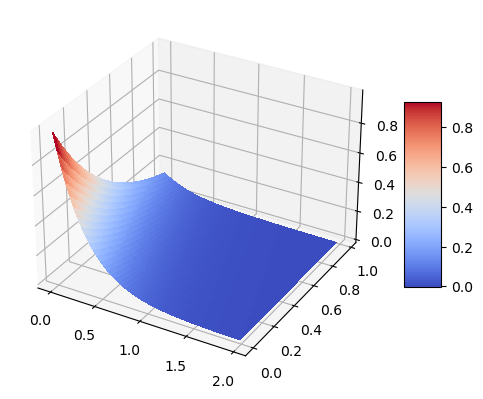

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = np.arange(0, 2, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = model(pt_x, pt_t)
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(
    ms_x, ms_t, ms_u, cmap="coolwarm", linewidth=0, antialiased=False
)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()